In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

## Getting Data

In [2]:
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

raw_data.head()

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


## Data Cleaning and processing

Tip amount is the target variable
The following data points are removed
+ some tip amount are zero means they were paid in cash 
+ Outliers where tip is more than fare
+ Some trips have very large fare cost
+ remove variable called the total amount as it already includes the tip

In [3]:
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it, namely the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

In [4]:
del raw_data
gc.collect()
# cleaning the memory

20

There are 2712719 observations in the dataset.
There are 17 variables in the dataset.


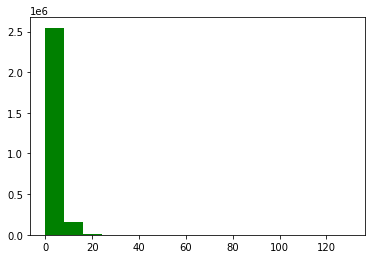

Minimum Tip amount value is  0.01
Maximum Tip amount value is  130.0


In [5]:
# print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum Tip amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum Tip amount value is ", np.max(clean_data.tip_amount.values))

In [6]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


Now we start preparing the data,we have pick up and drop off time
+  we will consider the hour 
+ Day 
+ Time taken or trip time in minutes
+ drop the date time 

In [7]:
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

clean_data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5,0,0,5,5,12.0
5,1,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5,0,0,5,5,10.0
7,1,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5,0,1,5,5,8.0
9,1,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5,0,1,5,5,34.0
10,2,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5,0,0,5,5,14.0


In [8]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
processed_data = pd.get_dummies(clean_data, columns = get_dummy_col)
del clean_data
gc.collect()

processed_data.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,...,pickup_day_4,pickup_day_5,pickup_day_6,dropoff_day_0,dropoff_day_1,dropoff_day_2,dropoff_day_3,dropoff_day_4,dropoff_day_5,dropoff_day_6
4,1.0,1.70,9.5,3.0,0.5,2.65,0.0,0.3,2.5,12.0,...,0,1,0,0,0,0,0,0,1,0
5,2.0,1.60,9.5,3.0,0.5,1.00,0.0,0.3,2.5,10.0,...,0,1,0,0,0,0,0,0,1,0
7,2.0,1.20,7.5,3.0,0.5,1.00,0.0,0.3,2.5,8.0,...,0,1,0,0,0,0,0,0,1,0
9,1.0,8.60,31.5,3.0,0.5,7.05,0.0,0.3,2.5,34.0,...,0,1,0,0,0,0,0,0,1,0
10,1.0,1.74,11.0,0.5,0.5,2.96,0.0,0.3,2.5,14.0,...,0,1,0,0,0,0,0,0,1,0


In [9]:
totval=500000
processed_data=processed_data.head(totval)
y = processed_data[['tip_amount']].values.astype('float32')
processed_data = processed_data.drop(['tip_amount'], axis=1)
X = processed_data.values
X = normalize(X, axis=1, norm='l1', copy=False)
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (500000, 596) y.shape= (500000, 1)


## train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (350000, 596) Y_train.shape= (350000, 1)
X_test.shape= (150000, 596) Y_test.shape= (150000, 1)


## Decision Tress Regression Model from Scikit learn

In [11]:
from sklearn.tree import DecisionTreeRegressor
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  23.59189


## Decision Tree Regression Model from Snap ML

In [12]:
from snapml import DecisionTreeRegressor
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  5.03017


In [15]:
from sklearn.metrics import mean_absolute_error
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

sklearn_pred = sklearn_dt.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))
sklearn_mae=mean_absolute_error(y_test, sklearn_pred)
print('[Scikit-Learn] Mean Absolute error score : {0:.3f}'.format(sklearn_mae))

snapml_pred = snapml_dt.predict(X_test)
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))
snapml_mae = mean_absolute_error(y_test, snapml_pred)
print('[Snap ML] Mean Absolute Error score : {0:.3f}'.format(snapml_mae))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 4.69x 
[Scikit-Learn] MSE score : 1.704
[Scikit-Learn] Mean Absolute error score : 0.733
[Snap ML] MSE score : 1.761
[Snap ML] Mean Absolute Error score : 0.733
